# Visualization of Results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import sympy
import pickle


from DAG_search import utils
from DAG_search import config
from DAG_search import dag_search
from DAG_search import comp_graph

In [2]:
import importlib
importlib.reload(config)
importlib.reload(dag_search)
importlib.reload(comp_graph)
importlib.reload(utils)

<module 'DAG_search.utils' from 'C:\\Users\\Paul Kahlmeyer\\OneDrive\\PhD\\DAG_search\\DAG_search\\utils.py'>

In [3]:
from regressors import regressors

In [4]:
importlib.reload(regressors)

<module 'regressors.regressors' from 'C:\\Users\\Paul Kahlmeyer\\OneDrive\\PhD\\DAG_search\\regressors\\regressors.py'>

In [5]:
import pickle
ds_name = 'Nguyen' # Strogatz, Feynman, Nguyen
   
load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)

In [6]:
for problem_name in task_dict:
    X = task_dict[problem_name]['X']
    if X.shape[1] == 1:
        print(problem_name)

Nguyen-1
Nguyen-2
Nguyen-3
Nguyen-4
Nguyen-5
Nguyen-6
Nguyen-7
Nguyen-8


In [16]:
problem_name = 'Nguyen-8'
X, y, expr_true = task_dict[problem_name]['X'], task_dict[problem_name]['y'], task_dict[problem_name]['expr'][0]

In [17]:
expr_true

x_0**0.5

In [18]:
importlib.reload(regressors)

<module 'regressors.regressors' from 'C:\\Users\\Paul Kahlmeyer\\OneDrive\\PhD\\DAG_search\\regressors\\regressors.py'>

In [19]:
regressor = regressors.ESR(path_to_eqs = 'regressors/core_maths', max_complexity = 5, verbose = 1)

In [20]:
regressor.fit(X, y[:, 0])

Complexity 1
Best expression: 1.4347400686779754	Loss: 0.2325213462647636
Complexity 2
Best expression: 1.4347400823622372	Loss: 0.23252134626476356
Complexity 3
Best expression: x_0**0.49999999525593997	Loss: 6.413079092478895e-17


In [21]:
pred = regressor.predict(X)

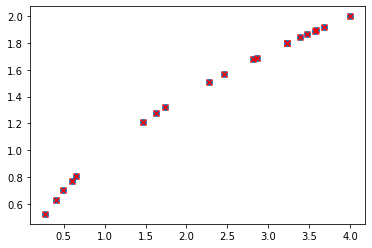

In [22]:
plt.scatter(X[:, 0], y[:, 0])
plt.scatter(X[:, 0], pred, color = 'red', marker = 'x')

In [23]:
regressor.model()

x_0**0.49999999525593997

## Experiment: local minima

Takeaway: We have lots of local minima that are symbolically different from each other

In [62]:
load_path = 'results/local_minima_exp.p'
with open(load_path, 'rb') as handle:
    results = pickle.load(handle)

Text(0, 0.5, '#Components among top 100')

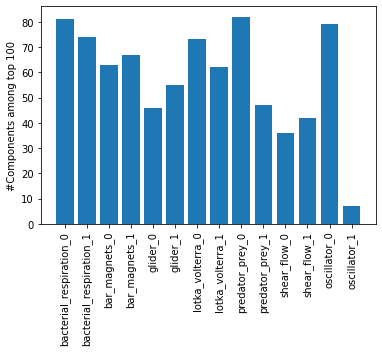

In [63]:
names = list(results.keys())
values = [results[n]['groups'] for n in names]
plt.bar(range(len(names)), values)
plt.xticks(range(len(names)), names, rotation = 90)
plt.ylabel(f'#Components among top {results[names[0]]["topk"]}')

## Experiment: Black Box vs. Symbolic

Takeaway: If you care about model fit, use Black Box. 

In [12]:
import pickle
regs = ['linreg', 'polyreg2', 'polyreg3', 'operon', 'gplearn', 'DAGSearch', 'MLP']
ds_name = 'Feynman' # Strogatz, Feynman, Nguyen  

Read Results

In [13]:
from sklearn.metrics import r2_score
# read results
res = {}
for regressor_name in regs:
    load_path = f'results/{ds_name}/{regressor_name}_results.p'
    if os.path.exists(load_path):
        res[regressor_name] = {}
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)

        # avg. recovery
        recoveries = []
        for problem in results_dict.keys():
            for rec in results_dict[problem]['recovery']:
                recoveries.append(rec)
        res[regressor_name]['recovery'] = np.mean(recoveries)


        # avg. RMSE
        rmses_train = []
        rmses_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_train.append(rmse)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_test.append(rmse)
        res[regressor_name]['rmse_train'] = np.mean(rmses_train)
        res[regressor_name]['rmse_test'] = np.mean(rmses_test)

        # median R2
        r2s_train = []
        r2s_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                r2 = r2_score(y, pred)
                r2s_train.append(r2)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                r2 = r2_score(y, pred)
                r2s_test.append(r2)
        res[regressor_name]['r2_train'] = np.median(r2s_train)
        res[regressor_name]['r2_test'] = np.median(r2s_test)
            
        # expression size
        expr_sizes = []
        for problem in results_dict.keys():
            for expr in results_dict[problem]['exprs']:
                expr_sizes.append(utils.tree_size(expr))
        if len(expr_sizes) > 0:
            res[regressor_name]['complexity'] = np.median(expr_sizes)

Make Scatter Plot

In [372]:
def get_pareto_idxs(obj1, obj2):
    M = np.column_stack([obj1, obj2])
    ret = []
    for i, p in enumerate(M):
        is_dominated = np.any(np.all(M < p, axis = 1))
        if not is_dominated:
            ret.append(i)
    return np.array(ret)

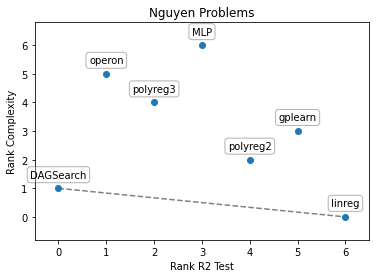

In [373]:
cat_x, name_x = 'r2_test', 'R2 Test'
#cat_x, name_x = 'recovery', 'Recovery'
def_value_x = 0.0
cat_y, name_y = 'complexity', 'Complexity'
def_value_y = np.inf

# assume lower is better (negate R2, recovery)
v1 = -np.array([res[regressor_name][cat_x] if cat_x in res[regressor_name] else def_value_x for regressor_name in regs])
v2 = np.array([res[regressor_name][cat_y] if cat_y in res[regressor_name] else def_value_y for regressor_name in regs])

ranks_x = np.argsort(np.argsort(v1))
ranks_y = np.argsort(np.argsort(v2))


pareto_idxs = get_pareto_idxs(ranks_x, ranks_y)
pareto_idxs = pareto_idxs[np.argsort([ranks_x[i] for i in pareto_idxs])] # sort by x rank (for plotting)

plt.scatter(ranks_x, ranks_y, zorder = 1)
plt.plot([ranks_x[i] for i in pareto_idxs], [ranks_y[i] for i in pareto_idxs], color = 'gray', linestyle = '--', zorder = 0)


# add labels
offset_x = 0.5
offset_y = 0.8
for i in range(len(regs)):
    s = regs[i]
    x = ranks_x[i]
    y = ranks_y[i] + .3
    ha = 'center'
    va = 'bottom'
    plt.text(s = s, x = x, y = y, ha = ha, va = va, bbox=dict(facecolor='w', edgecolor='black', boxstyle='round', alpha=0.3))
plt.xlim(0-offset_x, len(regs)-1+offset_x)
plt.ylim(0-offset_y, len(regs)-1+offset_y)
plt.xticks(range(len(regs)))
plt.yticks(range(len(regs)))

plt.xlabel(f'Rank {name_x}')
plt.ylabel(f'Rank {name_y}')
plt.title(f'{ds_name} Problems')


if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig(f'results/figures/scatterplot_{ds_name}.pdf', bbox_inches = 'tight')

## Experiment: Symbolic vs. Numeric Proximity
Takeaway: Symbolic Measures do not correlate with Numeric Measures

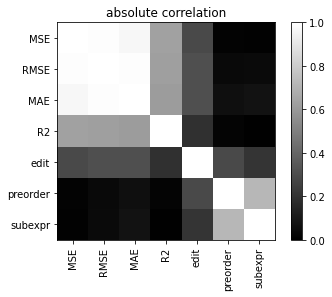

In [381]:
corr_matrix = np.load('results/corr_matrix.npy')
with open(f'results/distance_dict.p', 'rb') as handle:
    dist_dict = pickle.load(handle)
methods = list(dist_dict.keys())


plt.imshow(np.abs(corr_matrix), vmin = 0, vmax = 1, cmap = 'gray')
plt.colorbar()
plt.xticks(range(corr_matrix.shape[0]), methods, rotation = 90)
plt.yticks(range(corr_matrix.shape[0]), methods)
plt.title('absolute correlation')

if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig('results/figures/corr_plot.pdf', bbox_inches = 'tight')

## Experiment: Recovery

Takeaways:

- More nodes $\rightarrow$ better results, worse computation time

In [5]:
import pickle
ds_name = 'Feynman' # Strogatz, Feynman, Nguyen
mode = 'sampling' # exhaustive, sampling

with open(f'results/{ds_name}/{mode}_results.p', 'rb') as handle:
    results_dict = pickle.load(handle)
    
load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)

In [6]:
# absolute recovery
total_rec = 0.0
for problem in results_dict:
    rec = results_dict[problem]['recovery']
    print(problem, rec)
    total_rec += np.mean(rec)
total_rec /= len(results_dict)
print(f'Recovery: {total_rec}')

I.10.7 [False]
I.11.19 [False]
I.12.1 [True]
I.12.11 [False]
I.12.2 [False]
I.12.4 [True]
I.12.5 [True]
I.13.12 [False]
I.13.4 [False]
I.14.3 [True]
I.14.4 [True]
I.15.3t [False]
I.15.3x [False]
I.16.6 [False]
I.18.12 [False]
I.18.14 [False]
I.18.4 [False]
I.24.6 [False]
I.25.13 [True]
I.27.6 [False]
I.29.16 [False]
I.29.4 [True]
I.30.3 [False]
I.32.17 [False]
I.32.5 [False]
I.34.1 [False]
I.34.14 [False]
I.34.27 [True]
I.34.8 [True]
I.37.4 [False]
I.38.12 [False]
I.39.1 [True]
I.39.11 [True]
I.39.22 [True]
I.40.1 [False]
I.41.16 [False]
I.43.16 [True]
I.43.31 [True]
I.43.43 [False]
I.44.4 [False]
I.47.23 [False]
I.50.26 [False]
I.6.2 [False]
I.6.2a [False]
I.6.2b [False]
I.8.14 [False]
I.9.18 [False]
II.10.9 [False]
II.11.20 [False]
II.11.27 [False]
II.11.28 [False]
II.11.3 [False]
II.13.17 [False]
II.13.23 [False]
II.13.34 [False]
II.15.4 [False]
II.15.5 [False]
II.2.42 [False]
II.21.32 [False]
II.24.17 [False]
II.27.16 [True]
II.27.18 [True]
II.3.24 [True]
II.34.11 [False]
II.34.2 [

In [356]:
problem = 'I.24.6'

idx = 0
X, y, expr_true = task_dict[problem]['X'], task_dict[problem]['y'], task_dict[problem]['expr']
graph = results_dict[problem]['graphs'][idx]
consts = results_dict[problem]['consts'][idx]

MSE: 4.417842973694348


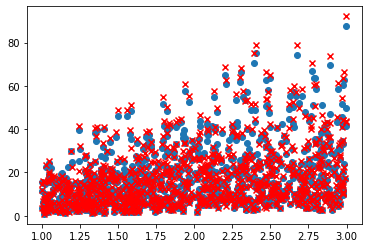

In [334]:
pred = graph.evaluate(X, c = consts)
mse = np.mean((pred[:, 0] - y[:, idx])**2)
print(f'MSE: {mse}')

plt.scatter(X[:, 0], y[:, idx])
plt.scatter(X[:, 0], pred[:, 0], marker = 'x', color = 'red')

In [335]:
graph.evaluate_symbolic()

[c_0*x_0*x_1*x_2*x_3**2]

In [336]:
consts

array([0.53])